In [47]:
from tensorflow.keras.utils import normalize
import os
import glob
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import albumentations as A
import albumentations.augmentations.functional as F
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

In [48]:
# !pip list
# !pip install opencv-python-headless==4.1.2.30

In [49]:
from google.colab import drive

In [50]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:

# #Resizing images, if needed
# SIZE_X = 256 
# SIZE_Y = 256
# n_classes=24  # number of classes for segmentation

# #Capture training image info as a list
# train_images = []
root = os.path.join('/content/drive/MyDrive/Data')
images_directory = os.path.join(root, 'image_dataset')
masks_directory = os.path.join(root, 'binary_mask_dataset')


Size = 256
        

In [52]:
img_names = glob.glob('/content/drive/MyDrive/Data/image_dataset/*.jpg')
msk_names = glob.glob('/content/drive/MyDrive/Data/binary_mask_dataset/*.png')
print(len(img_names), len(msk_names))

361 361


In [53]:
# img_names.sort()
# msk_names.sort()

In [54]:
# def preprocess_mask(mask):
#     #mask = mask.astype(np.int32)
#     #mask[mask != 3] = 0
#     mask[ (mask == 0) | (mask == 1) | (mask == 3) | (mask == 4) | (mask == 5) | (mask == 8) | (mask == 10)
#      | (mask == 11) | (mask == 13) | (mask == 14) | (mask == 15) | (mask == 16) | (mask == 17) | (mask == 18) | (mask == 19) | (mask == 20)
#       | (mask == 21) | (mask == 23) | (mask == 24)] = 0
#     mask[mask == 2] = 1 # grass
#     mask[mask == 9] = 2 # dog
#     mask[mask == 6] = 3 # tree
#     mask[mask == 7] = 4 # sky
#     mask[ (mask == 12) | (mask == 22)] = 5 # concrete/walkway
    
#     return mask

In [55]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:266]
val_images_filenames = correct_images_filenames[266:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))


266 85 10


In [56]:
# !pip install -U albumentations
!pip install --upgrade git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-anq47vnd
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-anq47vnd


In [57]:
import albumentations as album
from albumentations.pytorch import ToTensorV2

In [58]:
# class_names = ['background','ball','grass','person','tree','sky','building','dog','house','car',
#                     'concrete','dirt','rock','vase','wood','cat','wall','water','hose','hose_machine',
#                     'walkway','mountain','pole','garbage_can']
class_names = ['background', 'grass', 'dog', 'tree', 'sky', 'concrete/walkway']
# class_rgb_values = [
                    # [0,0,0],[128,0,0],[0,128,0],[128,128,0],[0,0,128],[128,0,128],[0,128,128],
                    # [128,128,128],[64,0,0],[192,0,0],[64,128,0],[192,128,0],[64,0,128],[192,0,128],
                    # [64,128,128],[192,128,128],[0,64,0],[128,64,0],[0,192,0],[128,192,0],[0,64,128],
                    # [128,64,128],[0,192,128],[128,192,128]
                    # ]
class_rgb_values = [
                    [0,0,0], [0,128,0],[128,128,128], [0,0,128], [128,0,128], [128,0,0]
                    ]

In [59]:
# print(len(class_names), len(class_rgb_values))

In [60]:
select_classes = ['background', 'grass']
# select_classes = ['background','ball','grass','person','tree','sky','building','dog','house','car',
#                     'concrete','dirt','rock','vase','wood','cat','wall','water','hose','hose_machine',
#                     'walkway','mountain','pole','garbage_can']
#class_rgb_values = [[0,0,0], [0,128,0],[128,128,128], [0,0,128], [128,0,128], [128,0,0]]

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

# print('Selected classes and their corresponding RGB values in labels:')
# print('Class Names: ', class_names)
# print('Class RGB values: ', class_rgb_values)

In [61]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [62]:
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [63]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [64]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [65]:
class BackgroundDataset(torch.utils.data.Dataset):

    
    def __init__(
            self, 
            images_filenames,
            images_directory,
            masks_directory,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.resize(image, (256,256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.COLOR_BGR2RGB,
        )
        mask = cv2.resize(mask, (256,256))
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_filenames)

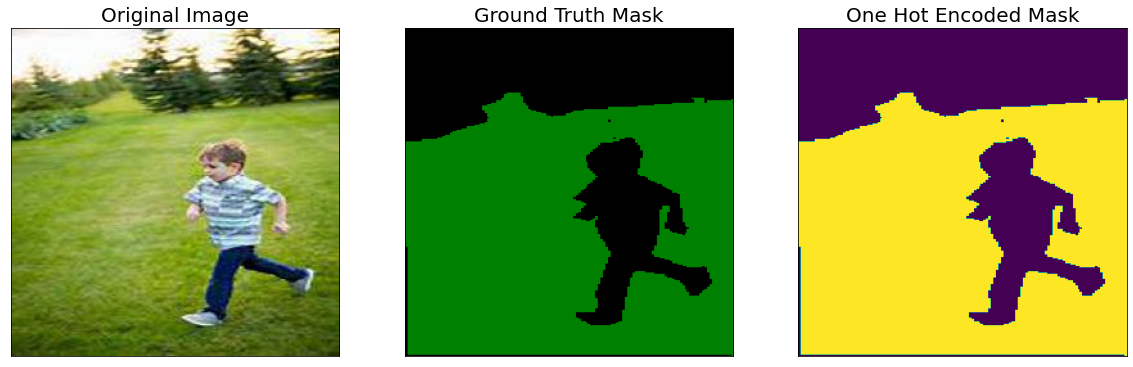

In [66]:
dataset = BackgroundDataset(images_filenames, images_directory, masks_directory, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[0]


visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [67]:
# ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
# pil = im = Image.fromarray((ground_truth_mask * 255).astype(np.uint8))
# pil

In [68]:
# allMask = BackgroundDataset(images_filenames, images_directory, masks_directory, class_rgb_values=select_class_rgb_values)
# random_idx = random.randint(0, len(dataset)-1)
# # image, mask = allMask
# names = []
# for mask in msk_names:
#     name = mask.rsplit('/', 1)[1]
#     # name = mask[-4:]
#     names.append(name)

# c = 0
# for i, (img, msk) in enumerate(allMask):
#   #name = 'img'+str(c)+'.png'
#   ground_truth_mask = colour_code_segmentation(reverse_one_hot(msk), select_class_rgb_values)
#   pil = im = Image.fromarray((ground_truth_mask * 255).astype(np.uint8))
#   pil.save('/content/drive/MyDrive/Data/mask_dataset2/' + names[i])
#   c+=1

In [69]:
def get_training_augmentation():
    train_transform = [
        album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

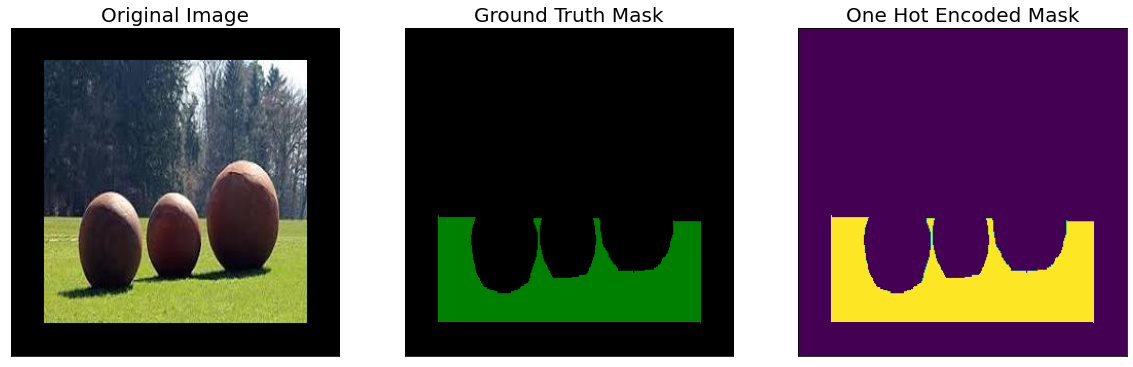

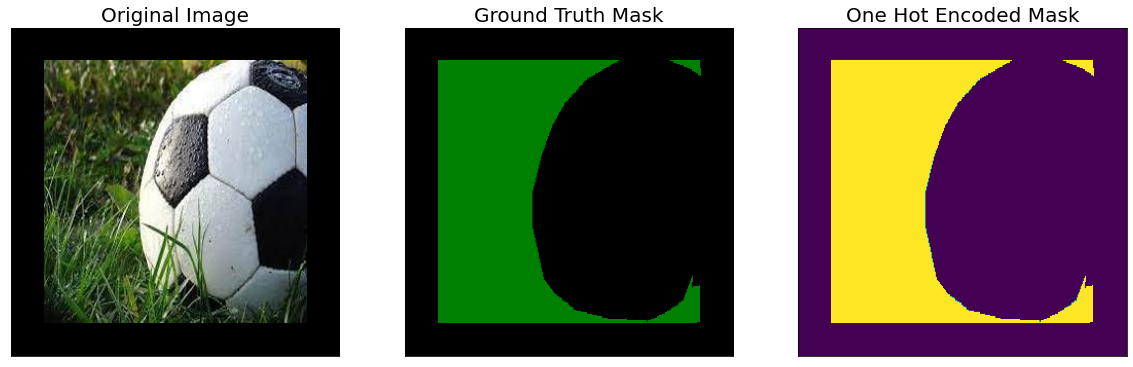

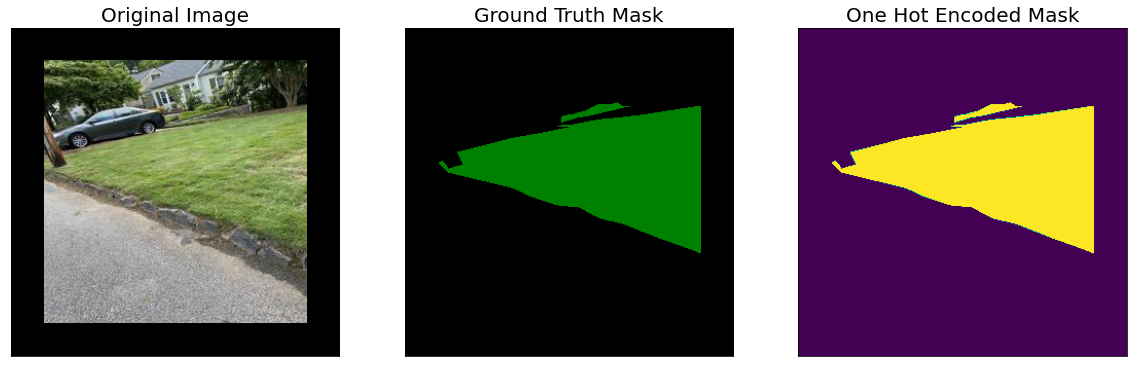

In [70]:
augmented_dataset = BackgroundDataset(
    train_images_filenames, images_directory, masks_directory, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [71]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null



In [72]:
import segmentation_models_pytorch as smp

In [73]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [74]:
# Get train and val dataset instances
train_dataset = BackgroundDataset(
    train_images_filenames, images_directory, masks_directory, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BackgroundDataset(
    val_images_filenames, images_directory, masks_directory, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=2)

In [75]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 15

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [76]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [77]:
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

In [78]:


if TRAINING:

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, '/content/drive/MyDrive/Data/GrassModel.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, dice_loss - 0.1783, iou_score - 0.8407]
Model saved!

Epoch: 1
valid: 100%|██████████| 22/22 [00:04<00:00,  5.27it/s, dice_loss - 0.1343, iou_score - 0.8795]
Model saved!

Epoch: 2
valid: 100%|██████████| 22/22 [00:04<00:00,  5.27it/s, dice_loss - 0.1068, iou_score - 0.9093]
Model saved!

Epoch: 3
valid: 100%|██████████| 22/22 [00:04<00:00,  5.31it/s, dice_loss - 0.1018, iou_score - 0.8921]

Epoch: 4
valid: 100%|██████████| 22/22 [00:04<00:00,  5.25it/s, dice_loss - 0.106, iou_score - 0.8608]

Epoch: 5
valid: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s, dice_loss - 0.07655, iou_score - 0.9133]
Model saved!

Epoch: 6
valid: 100%|██████████| 22/22 [00:04<00:00,  5.30it/s, dice_loss - 0.06961, iou_score - 0.9145]
Model saved!

Epoch: 7
valid: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s, dice_loss - 0.06256, iou_score - 0.9218]
Model saved!

Epoch: 8
valid: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s, dice_loss - 0.0

In [79]:
import os
import torch
# load best saved model checkpoint from the current run
# if os.path.exists('/content/drive/MyDrive/Data/GrassModel.pth'):
#     model = torch.load('/content/drive/MyDrive/Data/GrassModel.pth', map_location=torch.device('cpu'))
#     print('Loaded UNet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/unet-resnet50-for-scene-understanding-pytorch/best_model.pth'):
#     best_model = torch.load('../input/unet-resnet50-for-scene-understanding-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

In [80]:
class BackgroundDataset_Test(torch.utils.data.Dataset):

    
    def __init__(
            self, 
            images_filenames = None,
            images_directory = None,
            masks_directory = None,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.resize(image, (256,256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.COLOR_BGR2RGB,
        )
        mask = cv2.resize(mask, (256,256))
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_filenames)

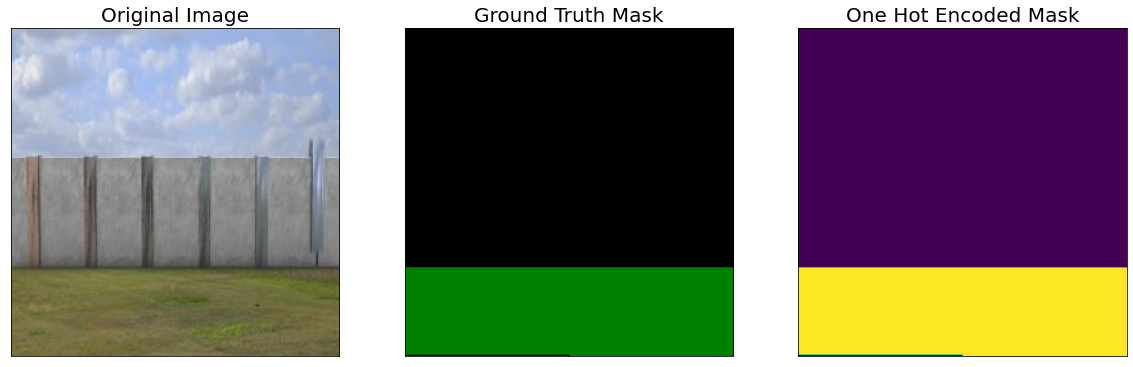

In [81]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BackgroundDataset_Test(
    test_images_filenames, images_directory, masks_directory,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = BackgroundDataset_Test(
    test_images_filenames, images_directory, masks_directory,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [82]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [83]:
sample_preds_folder = '/content/drive/MyDrive/Data/sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [84]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = model(x_tensor)
    # pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # from CHW format to HWC format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        
    )

Output hidden; open in https://colab.research.google.com to view.

In [85]:
test_epoch = smp.utils.train.ValidEpoch(
    model = model,
    # model = best_model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s, dice_loss - 0.05358, iou_score - 0.9144]
Evaluation on Test Data: 
Mean IoU Score: 0.9144
Mean Dice Loss: 0.0536


In [86]:
import pandas as pd

train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
dice_loss,0.289210,0.184585,0.136464,0.122561,0.101989,0.079708,0.066471,0.056663,0.046326,0.065805,0.048966,0.046385,0.048106,0.041787,0.043146
iou_score,0.717583,0.820152,0.874077,0.880189,0.896174,0.923293,0.935918,0.944340,0.953957,0.917057,0.943931,0.945634,0.939097,0.942018,0.941164


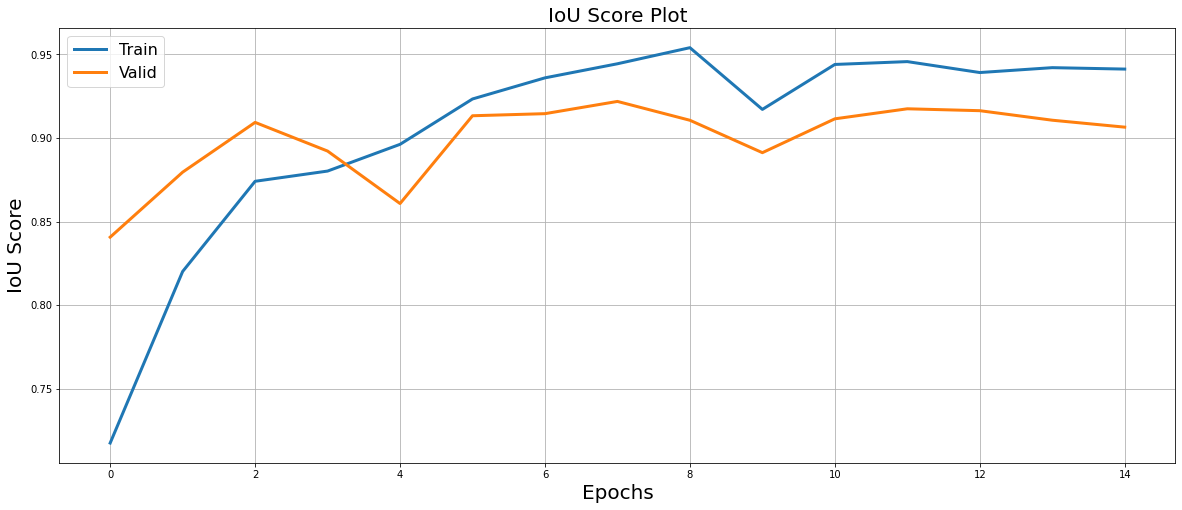

In [87]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

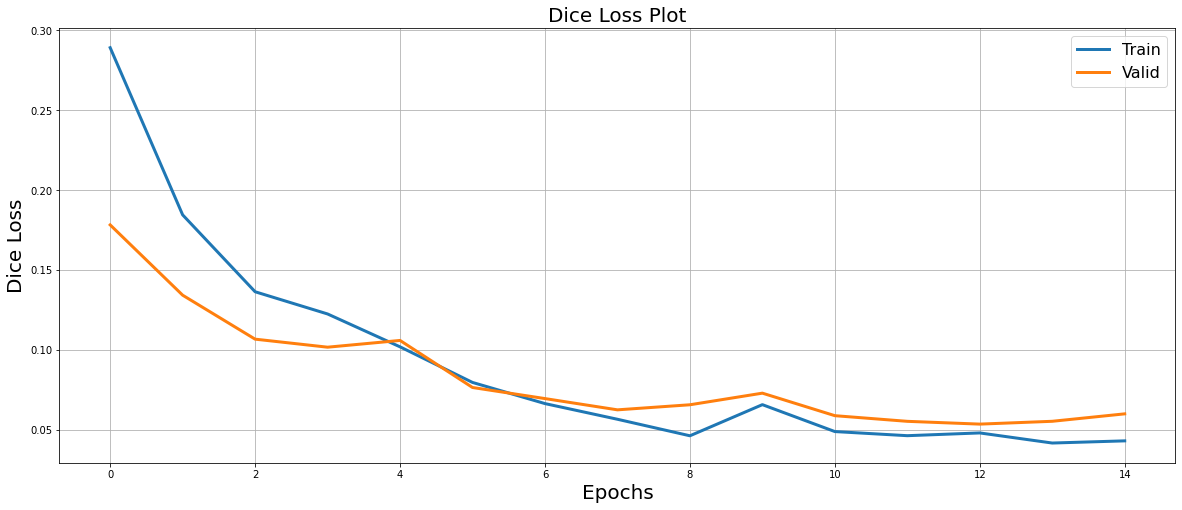

In [88]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()